## Import Libraries

In [ ]:
import nltk
import string
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
#download
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
! spacy download en_core_web_md

## Load Dataset

In [22]:
# Load the DataFrame from a CSV file
df = pd.read_csv('movies.csv')

## Data preprocessing

In [23]:
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize the words
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join the tokens back into a string
    text = ' '.join(tokens)
    return text

## Extract keywords using TFIDF

In [28]:
# Define the extract_keywords function
def extract_keywords(doc, n_keywords=10):
    # Create a TfidfVectorizer object
    vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2, 3))
    # Fit the vectorizer on the document
    vectorizer.fit([doc])
    # Transform the document into a TF-IDF matrix
    tfidf_matrix = vectorizer.transform([doc])
    # Convert the matrix to a dict of keywords
    keyword_dict = dict(zip(vectorizer.get_feature_names(), tfidf_matrix.toarray()[0]))
    # Return the top n keywords as a list of tuples
    return sorted(keyword_dict.items(), key=lambda x: x[1], reverse=True)[:n_keywords]

## Apply preprocessing and extracting hotkeywords TFIDF

In [29]:
# Apply the extract_keywords function to each row of the DataFrame
df['wiki_plot_tfidf'] = df['wiki_plot'].apply(preprocess)
#df['pre'] = df['wiki_plot'].apply(preprocess)
df['keywords'] = df['wiki_plot_tfidf'].apply(extract_keywords)

# Print the top 10 hot keywords for each row of the DataFrame
for i, row in df.iterrows():
    print(f"Top keywords for row {i+1}:")
    for keyword, score in row['keywords']:
        print(keyword, score)
    print("\n")


Top keywords for row 1:
la vega 0.11908964870367486
five family 0.0850640347883392
moe greene 0.0850640347883392
assassination attempt 0.06805122783067136
carlo questioned 0.06805122783067136
michael take 0.06805122783067136
new york 0.06805122783067136
role vito 0.06805122783067136
son michael 0.06805122783067136
emilio barzini 0.05103842087300351


Top keywords for row 2:
money laundering 0.09908223522576068
rock hammer 0.08256852935480057
solitary confinement 0.08256852935480057
another prison 0.06605482348384045
life sentence 0.06605482348384045
marriage figaro 0.06605482348384045
promise andy 0.06605482348384045
randall stephen 0.06605482348384045
warden norton 0.06605482348384045
bull queer 0.04954111761288034


Top keywords for row 3:
concentration camp 0.1364583830745404
nazi party 0.08528648942158774
factory produce 0.0682291915372702
factory schindler 0.0682291915372702
many people 0.0682291915372702
red coat 0.0682291915372702
schindlerjuden schindlerjuden 0.0682291915372702

## Extract keywords using TF

In [31]:
# Create a CountVectorizer object with n-gram range of 1 to 3
vectorizer = CountVectorizer(ngram_range=(1, 3))

# Fit the vectorizer to the data
df['wiki_plot_tf'] = df['wiki_plot'].apply(preprocess)
vectorizer.fit(df['wiki_plot_tf'])

# Create a function to get the top 10 hot keywords for a given text
def get_top_keywords(text):
    # Transform the text into a bag of words
    bow = vectorizer.transform([text])
    
    # Get the sum of term frequency for each word in the vocabulary
    tf = pd.DataFrame(bow.sum(axis=0), columns=vectorizer.get_feature_names()).T
    tf.columns = ['tf']
    
    # Sort the words by their term frequency in descending order
    tf = tf.sort_values(by='tf', ascending=False)
    
    # Get the top 10 hot keywords
    top_keywords = tf.head(10).index.tolist()
    
    return top_keywords

## Extract hot Keywords using TF

In [32]:
#df['wiki_plot'] = df['wiki_plot'].apply(preprocess)
df['top_keywords_TF'] = df['wiki_plot_tf'].apply(get_top_keywords)

# Print the top 10 hot keywords for each row
for i, row in df.iterrows():
    print(f"Row {i+1} top keywords:", row['top_keywords_TF'])

Row 1 top keywords: ['michael', 'vito', 'family', 'sonny', 'son', 'kay', 'greene', 'corleone', 'father', 'murder']
Row 2 top keywords: ['andy', 'prison', 'red', 'money', 'warden', 'norton', 'andys', 'guard', 'rock', 'solitary']
Row 3 top keywords: ['schindler', 'goeth', 'jew', 'war', 'factory', 'worker', 'nazi', 'stern', 'german', 'schindlerjuden']
Row 4 top keywords: ['jake', 'joey', 'vickie', 'new', 'know', 'salvy', 'brother', 'robinson', 'fight', 'film']
Row 5 top keywords: ['rick', 'laszlo', 'ilsa', 'letter', 'renault', 'german', 'husband', 'bogart', 'bergman', 'police']
Row 6 top keywords: ['mcmurphy', 'ratched', 'patient', 'billy', 'chief', 'candy', 'mcmurphys', 'window', 'escape', 'hospital']
Row 7 top keywords: ['scarlett', 'rhett', 'ashley', 'melanie', 'tara', 'home', 'war', 'scarletts', 'find', 'frank']
Row 8 top keywords: ['kane', 'kanes', 'thompson', 'susan', 'rosebud', 'estate', 'interview', 'xanadu', 'thatcher', 'interview kanes']
Row 9 top keywords: ['dorothy', 'witch', 

## Semantic Seearch using spacy

In [34]:
# Load the pre-trained word embedding model
nlp = spacy.load('en_core_web_md')

def semantic_search(query, documents, n_results=5):
    # Convert the query to a dense vector using the word embedding model
    query_vector = nlp(query).vector
    # Compute the cosine similarity between the query vector and each document vector
    document_vectors = [nlp(doc).vector for doc in documents]
    similarity_scores = cosine_similarity([query_vector], document_vectors)[0]
    # Return the indices of the top n_results documents based on the similarity scores
    top_indices = similarity_scores.argsort()[::-1][:n_results]
    return top_indices

# Define a query to search 
query = "How do I apply for a loan?"

# Extract the text and keywords from each document
texts = list(df['wiki_plot'])
keywords = list(df['keywords'])
keywords_tf = list(df['top_keywords_TF'])


# Perform semantic search
top_indices = semantic_search(query, texts, n_results=5)

# Print the top matching documents
for i, index in enumerate(top_indices):
    print(f"Rank {i+1}:")
    print(f"Text: {texts[index]}")
    print(f"Keywords: {keywords[index]}")
    print(f"Keywords_TF: {keywords_tf[index]}")
    print("\n")


Rank 1:
Text: film open joe buck jon voight young texan working dishwasher dress new cowboy clothing pack suitcase quits job head new york city hoping succeed male prostitute woman film open joe buck jon voight jon voight young texan texan working dishwasher dress new cowboy clothing pack suitcase quits job head new york city new york city hoping succeed male prostitute woman initially unsuccessful succeeds bedding welltodo middleaged new yorker sylvia mile joe end giving money failed understand call girl one expecting get paid initially unsuccessful succeeds bedding welltodo middleaged new yorker sylvia mile sylvia mile joe end giving money failed understand call girl call girl one expecting get paid joe meet enrico salvatore ratso rizzo dustin hoffman street con man limp take joe offering introduce known pimp turn bible thumper john mcgiver joe flees encounter pursuit ratso joe meet enrico salvatore ratso rizzo dustin hoffman dustin hoffman street con man con man limp take joe offeri

## Visualization for Data

Text(0.5, 1.0, 'Word Cloud on uncleaned text')

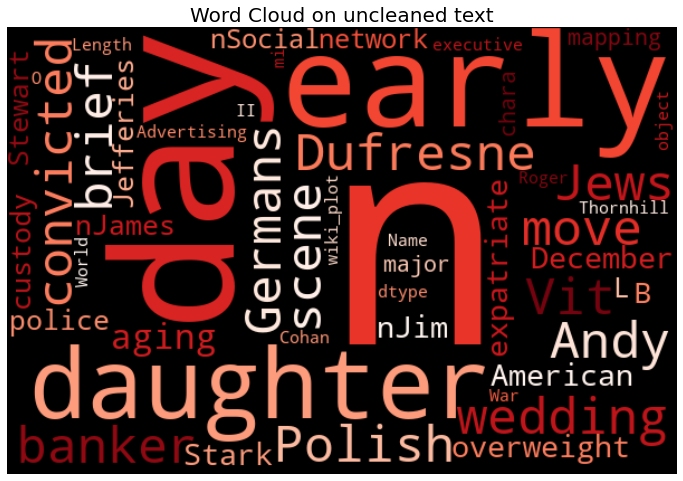

In [36]:
df = pd.read_csv('movies.csv')
df['wiki_plot_cleaned'] = df['wiki_plot'].apply(preprocess)
cloud=WordCloud(colormap="Reds",width=600,height=400).generate(str(df["wiki_plot"]))
fig=plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("Word Cloud on uncleaned text", size = 20)

Text(0.5, 1.0, 'Word Cloud on cleaned text')

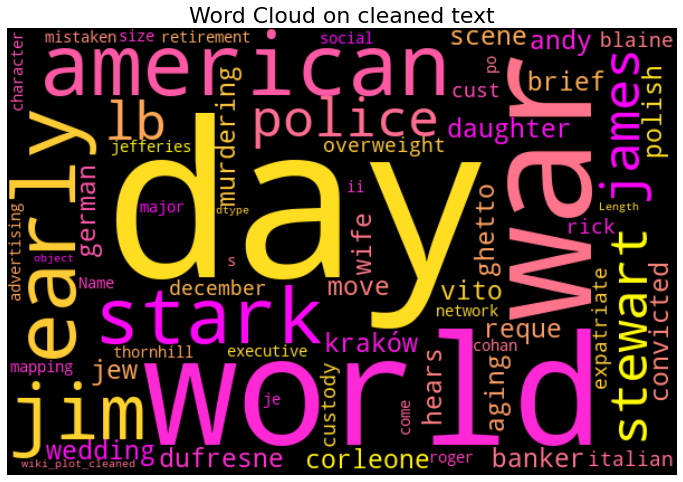

In [37]:
cloud=WordCloud(colormap="spring",width=600,height=400).generate(str(df['wiki_plot_cleaned']))
fig=plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("Word Cloud on cleaned text", size = 22)

In [ ]:
pd.set_option('display.max_colwidth', None)
df['wiki_plot_cleaned'].head()

## POS Tagging

In [63]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(str(df['wiki_plot_cleaned']))

## Frequency of POS tagger

Text(0.5, 0, 'POS tagger')

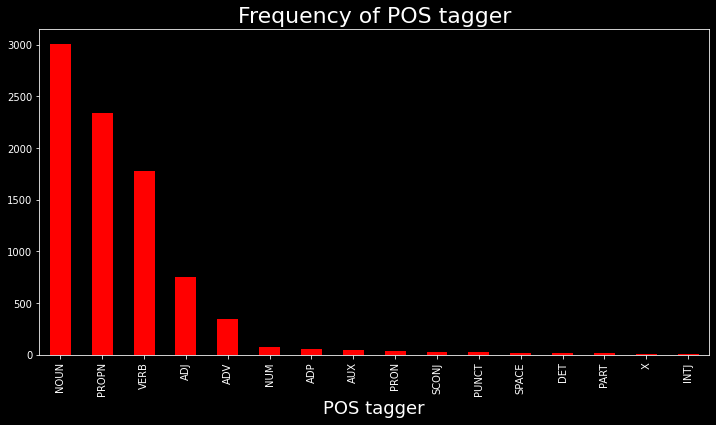

In [64]:
list = [token.pos_ for token in doc]
list = pd.Series(list)
plt.style.use("dark_background")
list.value_counts().plot(figsize = (12,6), kind = "bar", color = "r")
plt.title("Frequency of POS tagger", size = 22)
plt.xlabel("POS tagger", size = 18)

## Top 30 most frequent words

Text(0.5, 1.0, '30 most frequent words')

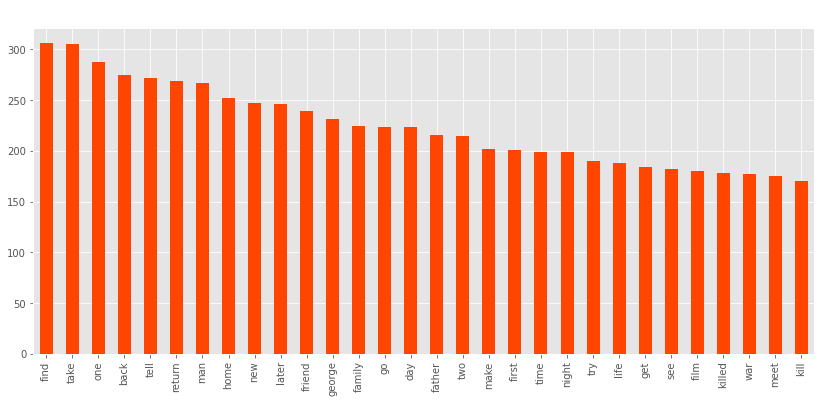

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(df["pre"]).split()).value_counts()[:30]
freq.plot(kind="bar", color = "orangered")
plt.title("30 most frequent words",size=20)